# Lecture 20 – part II            
                                            
## Basic spatial data visualization           
   - Hotels-Europe - with 'rgdal'          
     - Importing an shp file               
     - Visualize London Boroughs           
     - Show average prices on map          
     - Visualize Vienna districts          


Case-studies:

   - Ch03B Comparing hotel prices in Europe: Vienna vs London                      
                                             
Data used:

    hotels-europe                             

___

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from plotnine import *
import statsmodels.formula.api as smf
from datetime import datetime
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from stargazer.stargazer import Stargazer
import warnings

theme_map = [
    theme_minimal(),
    theme(
        axis_title_x=element_blank(),
        axis_title_y=element_blank(),
        panel_grid_minor=element_blank(),
        panel_grid=element_blank(),
        axis_text=element_blank(),
    ),
]
%matplotlib inline
warnings.filterwarnings("ignore")

Import Hotels-Europe data

In [2]:
heu_p = pd.read_csv("https://osf.io/p6tyr/download")
heu_f = pd.read_csv("https://osf.io/utwjs/download")
heu = heu_f.merge(heu_p, on = "hotel_id",how="left")
del heu_p, heu_f

Filter to London and Vienna as usual

In [3]:
heu = (
    heu.loc[lambda x: (x["year"] == 2017) & (x["month"] == 11) & (x["weekend"] == 0)]
    .loc[lambda x: x["city"].isin(["London", "Vienna"])]
    .loc[lambda x: x["accommodation_type"] == "Hotel"]
    .loc[lambda x: (x["stars"]) >= 3 & (x["stars"] <= 4)]
    .loc[lambda x: x["price"] < 600]
)

### 1) Visualize London Borough

Import shp file from [here](https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london)

Import shp file for London from the `data_map folder`

**Note:** you always need an 'shx' and 'dbf' file with the same name to read

In [4]:
london_map = gpd.read_file("data_map/London_Borough_Excluding_MHW.shp")

In [5]:
london_map.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18..."


In [6]:
london_map = london_map.rename(columns={"NAME":"borough"})

Show London boroughs

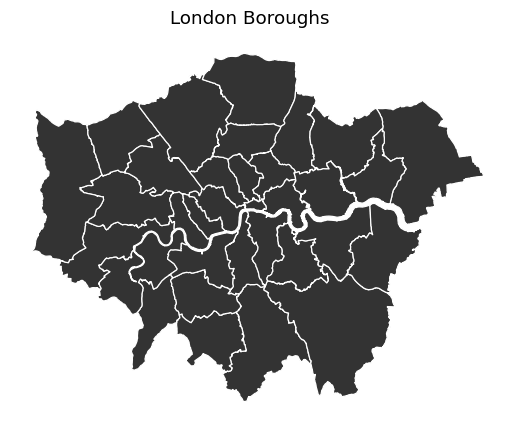

<ggplot: (683167594)>

In [7]:
(
    ggplot(london_map, aes(group="borough"))
    + geom_map(color="white")
    + coord_equal()
    + ggtitle("London Boroughs")
    + theme_map
)

Define inner-London boroughs 

Note: City of London officially is not inner-London

In [8]:
inner_boroughs = [
    "Camden",
    "Greenwich",
    "Hackney",
    "Hammersmith and Fulham",
    "Islington",
    "Kensington and Chelsea",
    "Lambeth",
    "Lewisham",
    "Southwark",
    "Tower Hamlets",
    "Wandsworth",
    "Westminster",
    "City of London",
]

In [9]:
london_map["inner_london"] = london_map["borough"].isin(inner_boroughs)

Show inner-London boroughs

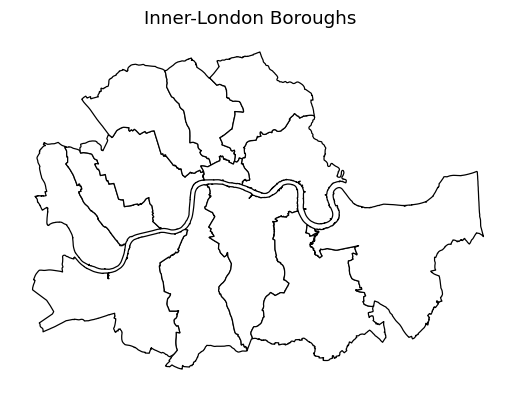

<ggplot: (677784763)>

In [10]:
inner_london = (
    ggplot(london_map.loc[lambda x: x["inner_london"] == True], aes(group="borough"))
    + geom_map(color="black", fill="white")
    + coord_equal()
    + ggtitle("Inner-London Boroughs")
    + theme_map
)
inner_london

Label boroughs on map by borough name

First calculate center point for each borough

In [11]:
london_map.crs = 'EPSG:3857'
london_map["center"] = london_map.geometry.centroid
london_map["x"] = [val.x for val in london_map.center]
london_map["y"] = [val.y for val in london_map.center]

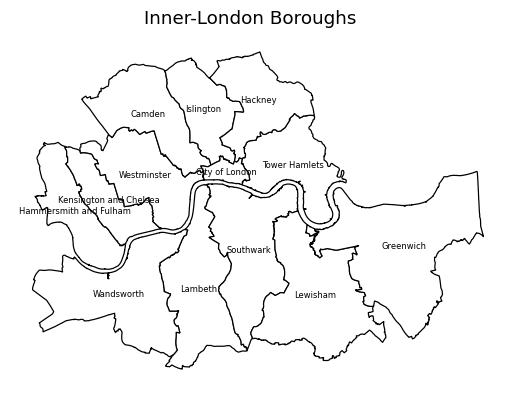

<ggplot: (685152329)>

In [12]:
(
    inner_london
    + geom_text(
        london_map.loc[lambda x: x["inner_london"] == True],
        aes(x="x", y="y", label="borough", size=8),
    )
    + scale_size_continuous(guide=False)
)

Add prices from London

1. Create a borough variable 

In [13]:
heu["borough"] = heu["neighbourhood"]

Hand-written matching...

In [14]:
match_london = {
    "Blackheath": "Lewisham",
    "Bloomsbury": "Camden",
    "Camden Town": "Camden",
    "Canary Wharf": "Tower Hamlets",
    "Chelsea": "Kensington and Chelsea",
    "Covent Garden": "Westminster",
    "Earl\\u0027s Court": "Kensington and Chelsea",
    "Euston": "Camden",
    "Hammersmith and Fulham": "Hammersmith and Fulham",
    "Hampstead": "Camden",
    "Kensington": "Kensington and Chelsea",
    "Kings Cross": "Islington",
    "Kings Cross St. Pancras": "Islington",
    "Knightsbridge": "Westminster",
    "Lillington and Longmoore Gardens": "Westminster",
    "London": "City of London",
    "Maida Vale": "Westminster",
    "Marylebone": "Westminster",
    "Mayfair": "Westminster",
    "North Maida Vale": "Westminster",
    "Notting Hill": "Kensington and Chelsea",
    "Paddington": "Westminster",
    "Poplar": "Tower Hamlets",
    "Royal Borough of Kensington and Chelsea": "Hammersmith and Fulham",
    "Shoreditch": "Hackney",
    "Soho": "Westminster",
    "South Bank": "Lambeth",
    "St Katharine\\u0027s \\u0026 Wapping": "Tower Hamlets",
    "Stratford": "Newham",
    "The City of London": "City of London",
    "Victoria": "Westminster",
    "West End": "Camden",
    "White City": "Hammersmith and Fulham",
}

In [15]:
heu["borough"] = heu["borough"].map(match_london).fillna(heu["borough"])

 Calculate the average prices in each borough, London

In [16]:
l_bor = (
    heu.loc[lambda x: x["city_actual"] == "London"]
    .groupby("borough")["price"]
    .mean()
    .to_frame()
    .reset_index()
)

merge to london map

In [17]:
london_map = london_map.merge(l_bor, how="left")

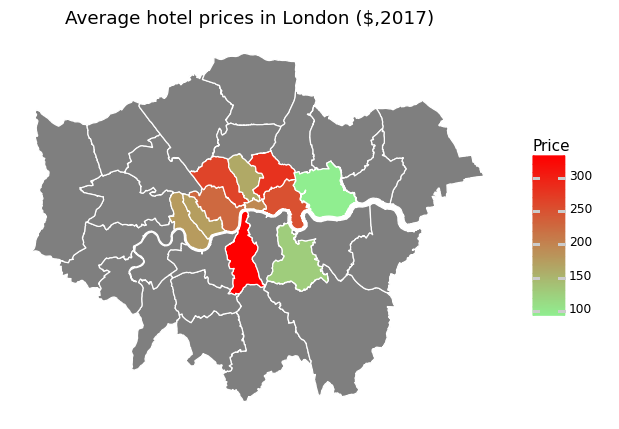

<ggplot: (685126581)>

In [18]:
(
    ggplot(london_map, aes(group="borough", fill="price"))
    + geom_map(color="white")
    + coord_equal()
    + labs(fill="Price")
    + scale_fill_gradient(
        low="lightgreen", high="red", name="Price"  # colors
    )  # legend options
    + ggtitle("Average hotel prices in London ($,2017)")
    + theme_map
)

Make nicer plot

In [19]:
london_map["borough"] = np.where(
    london_map["borough"] == "Hammersmith and Fulham", "H&F", london_map["borough"]
)
london_map["borough"] = np.where(
    london_map["borough"] == "Kensington and Chelsea", "K&C", london_map["borough"]
)
london_map["borough"] = np.where(
    london_map["borough"] == "City of London", "C.London", london_map["borough"]
)

In [20]:
palette = ["#9be3f9", "#0097c3", "#f24f26", "#ffef55", "#e1c5a3"]

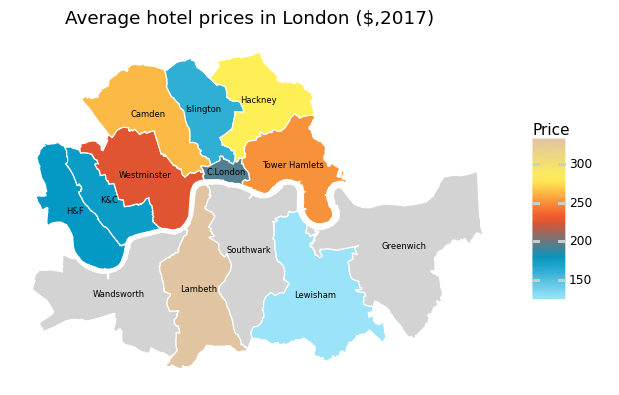

<ggplot: (685214847)>

In [21]:
(
    ggplot(
        london_map.loc[lambda x: x["inner_london"] == True],
        aes(group="borough", fill="price"),
    )
    + geom_map(color="white")
    + coord_equal()
    + labs(fill="Price")
    + scale_fill_gradientn(colors=palette, na_value="lightgrey", name="Price")
    + ggtitle("Average hotel prices in London ($,2017)")
    + theme_map
    + geom_text(aes(x="x", y="y", label="borough", size=8))
    + scale_size_continuous(guide=False)
)

### Task:

Do the same for hotels in Vienna

I have let the matching in the codes not to spend time with data-munging...


In [22]:
vienna_map = gpd.read_file("data_map/BEZIRKSGRENZEOGDPolygon.shp").rename(columns={"NAMEK":"district"})

 Visualize Vienna districts

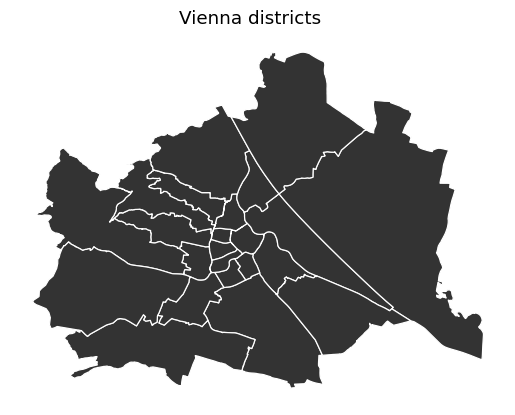

<ggplot: (677808526)>

In [23]:
(
    ggplot(vienna_map, aes(group="district"))
    + geom_map(color="white")
    #+ coord_equal() NOTE: somehow here we do not need coord_equal
    + ggtitle("Vienna districts")
    + theme_map
)

In [24]:
match_vienna = {
    "17. Hernals": "Hernals",
    "Graben": "Innere Stadt",
    "Kaerntner Strasse": "Innere Stadt",
    "Landstrasse": "Landstra\xdfe",
    "Rudolfsheim-Funfhaus": "Rudolfsheim-F\xfcnfhaus",
    "Wahring": "W\xe4hring",
    "Schonbrunn": "Meidling",
}

 Rename the variable: if ugly name from vienna_map, use the pretty name instead!

In [25]:
heu["borough"] = heu["borough"].map(match_vienna).fillna(heu["borough"])

 Average prices in vienna districts

In [26]:
v_dist = (
    heu.loc[lambda x: x["city_actual"] == "Vienna"]
    .groupby("borough")["price"]
    .mean()
    .to_frame()
    .reset_index()
    .rename(columns={"borough": "district"})
)

In [27]:
vienna_map = vienna_map.merge(v_dist, on = "district", how = "left")

In [28]:
vienna_map.crs = 'EPSG:3857'
vienna_map["center"] = vienna_map.geometry.centroid
vienna_map["x"] = [val.x for val in vienna_map.center]
vienna_map["y"] = [val.y for val in vienna_map.center]

In [29]:
vienna_map["district"] = (
    vienna_map["district"]
    .str.strip()
    .map(
        {
            "D\xf6bling": "Dobling",
            "Rudolfsheim-Fünfhaus": "R-F",
            "Innere Stadt": "I.S.",
            "Josefstadt": "Josefs.",
            "Alsergrund": "Agrund",
            "Mariahilf": "Mhilf.",
            "Margareten": "Mgaret.",
        }
    )
    .fillna(vienna_map["district"])
)

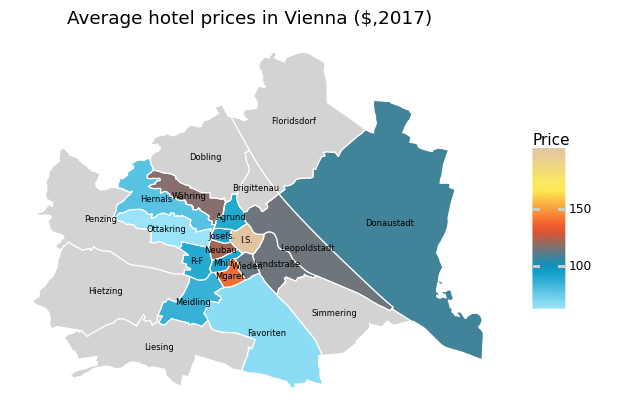

<ggplot: (685295475)>

In [30]:
(
    ggplot(vienna_map, aes(group="district", fill="price"))
    + geom_map(color="white")
    + labs(fill="Price")
    + scale_fill_gradientn(colors=palette, na_value="lightgrey", name="Price")
    + ggtitle("Average hotel prices in Vienna ($,2017)")
    + theme_map
    + geom_text(aes(x="x", y="y", label="district", size=8))
    + scale_size_continuous(guide=False)
)

Show the two cities in one plot

In [31]:
london_map = (
    london_map.loc[lambda x: x["inner_london"] == True]
    .filter(["borough", "geometry", "price", "x", "y"])
    .assign(city="Inner-London")
)

vienna_map = (
    vienna_map.filter(["district", "geometry", "price", "x", "y"])
    .rename(columns={"district": "borough"})
    .assign(city="Vienna")
)

vienna_london_map = pd.concat([vienna_map, london_map])

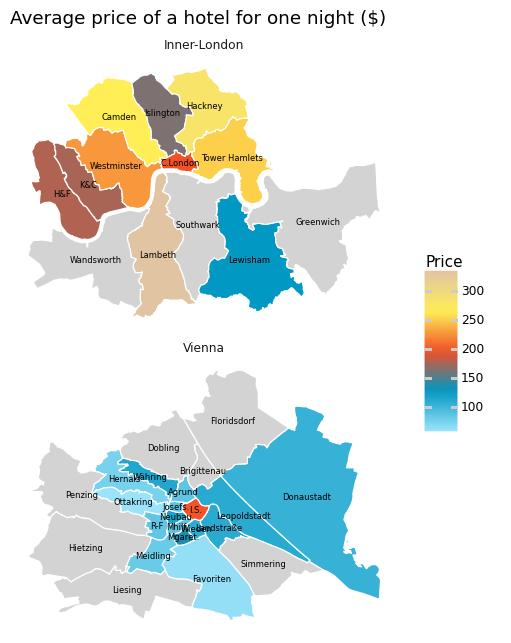

<ggplot: (685353421)>

In [32]:
heu_prices = (
    ggplot(vienna_london_map, aes(group="borough", fill="price"))
    + geom_map(color="white")
    + scale_fill_gradientn(colors=palette, na_value="lightgrey", name="Price")
    + geom_text(aes(x="x", y="y", label="borough", size=8))
    + facet_wrap("city", nrow=2, scales="free")
    + coord_equal()
    + scale_size_continuous(guide=False)
    + ggtitle("Average price of a hotel for one night ($)")
    + labs(fill="Price")
    + theme_map
    + theme(figure_size=(5, 7.5))
)
heu_prices

NOTE: the coordinates are not  perfectly equally distanced

In [33]:
ggsave(plot=heu_prices, filename='output/heu_prices.png', dpi=500)